In [1]:
import time

import matplotlib.pyplot as plt
import keras
import os
from scipy.special import softmax
import seaborn
from sklearn import metrics

In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
font = {'size'   : 22}
plt.rc('font', **font)

# Affective Computing

In [3]:
affective_model = keras.models.load_model("models/AffectInceptionResNetV3.keras")

/Users/benhoskings/Documents/Pycharm/Hero_Monitor/venv2/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 354 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [4]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/FusionV2"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Negative", "Neutral", "Positive"]
batch_size = 128
image_shape = (224, 224, 3)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_path_structured, "val_set"), 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=image_shape[0:2],
    seed=101, 
    shuffle=False)

Found 1500 files belonging to 3 classes.


In [5]:
print("Evaluate")
# result = affective_model.evaluate(val_ds)
# print(dict(zip(affective_model.metrics_names, result)))
start = time.monotonic()
predictions = affective_model.predict(val_ds)
print(f"Avg prediction time: {(time.monotonic() - start) / 1500}s")

Evaluate
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Avg prediction time: 0.01565529091663969s


In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np

pred_classes = np.argmax(predictions, axis=1)
true_categories = np.concatenate([y for x, y in val_ds], axis=0)

metrics.accuracy_score(np.argmax(true_categories, axis=1), pred_classes)

0.7746666666666666

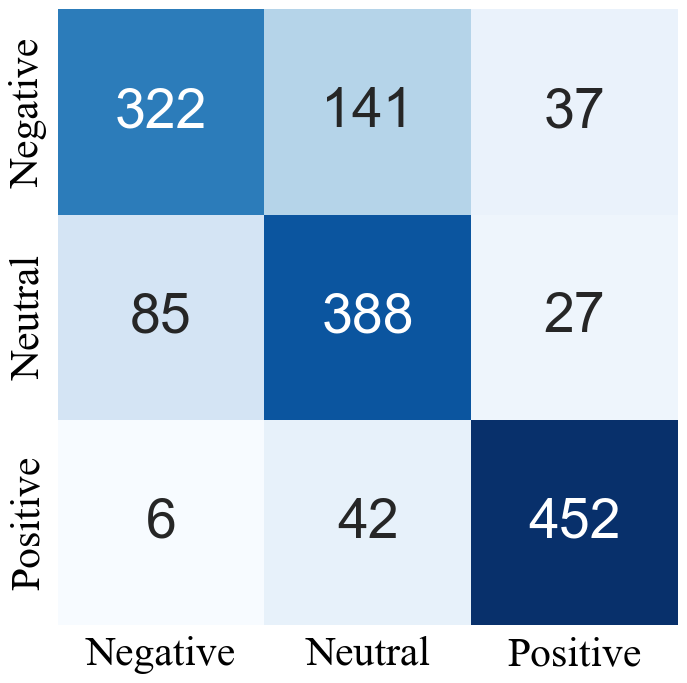

In [7]:
class_names = ["Negative", "Neutral", "Positive"]
font_dict={'size': 30, 'color': 'black', "family": "serif", "name": "Times New Roman"}
cm = confusion_matrix(y_true=np.argmax(true_categories, axis=1), y_pred=pred_classes)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
seaborn.set(font_scale=1.4) #for label size
seaborn.heatmap(cm, annot=True, annot_kws={"size": 40}, cbar = False, cmap='Blues', fmt='d')
ax1.set_yticklabels(class_names, fontdict=font_dict)
ax1.set_xticklabels(class_names, fontdict=font_dict)
# ax1.set_ylabel('True Values', fontdict=font_dict)
# ax1.set_xlabel('Predicted Values',fontsize=14)

plt.savefig("figures/affective_confusion_matrix.png", bbox_inches='tight')
plt.show()

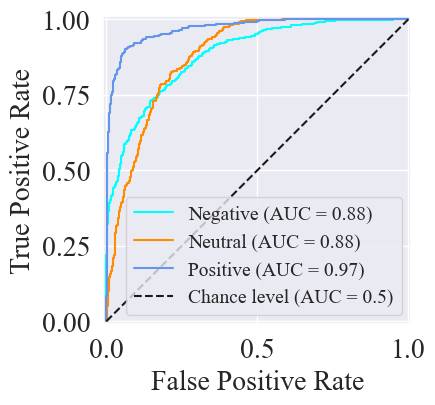

In [30]:
from sklearn.metrics import RocCurveDisplay
class_names = ["Negative", "Neutral", "Positive"]
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams.update({'font.size': 50})
plt.rc('font', size=30) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

fig, ax = plt.subplots(figsize=(4, 4))
colours = ["aqua", "darkorange", "cornflowerblue"]
for class_id in [0, 1, 2]:
    display = RocCurveDisplay.from_predictions(
        true_categories[:, class_id],
        predictions[:, class_id],
        name=f"{class_names[class_id]}",
        color=colours[class_id],
        plot_chance_level=(class_id == 2),
        ax=ax
    )
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate"
)

# display.ax_.legend = class_names
plt.savefig("figures/affective_classifier_roc.png", bbox_inches='tight')

Found 1500 files belonging to 3 classes.


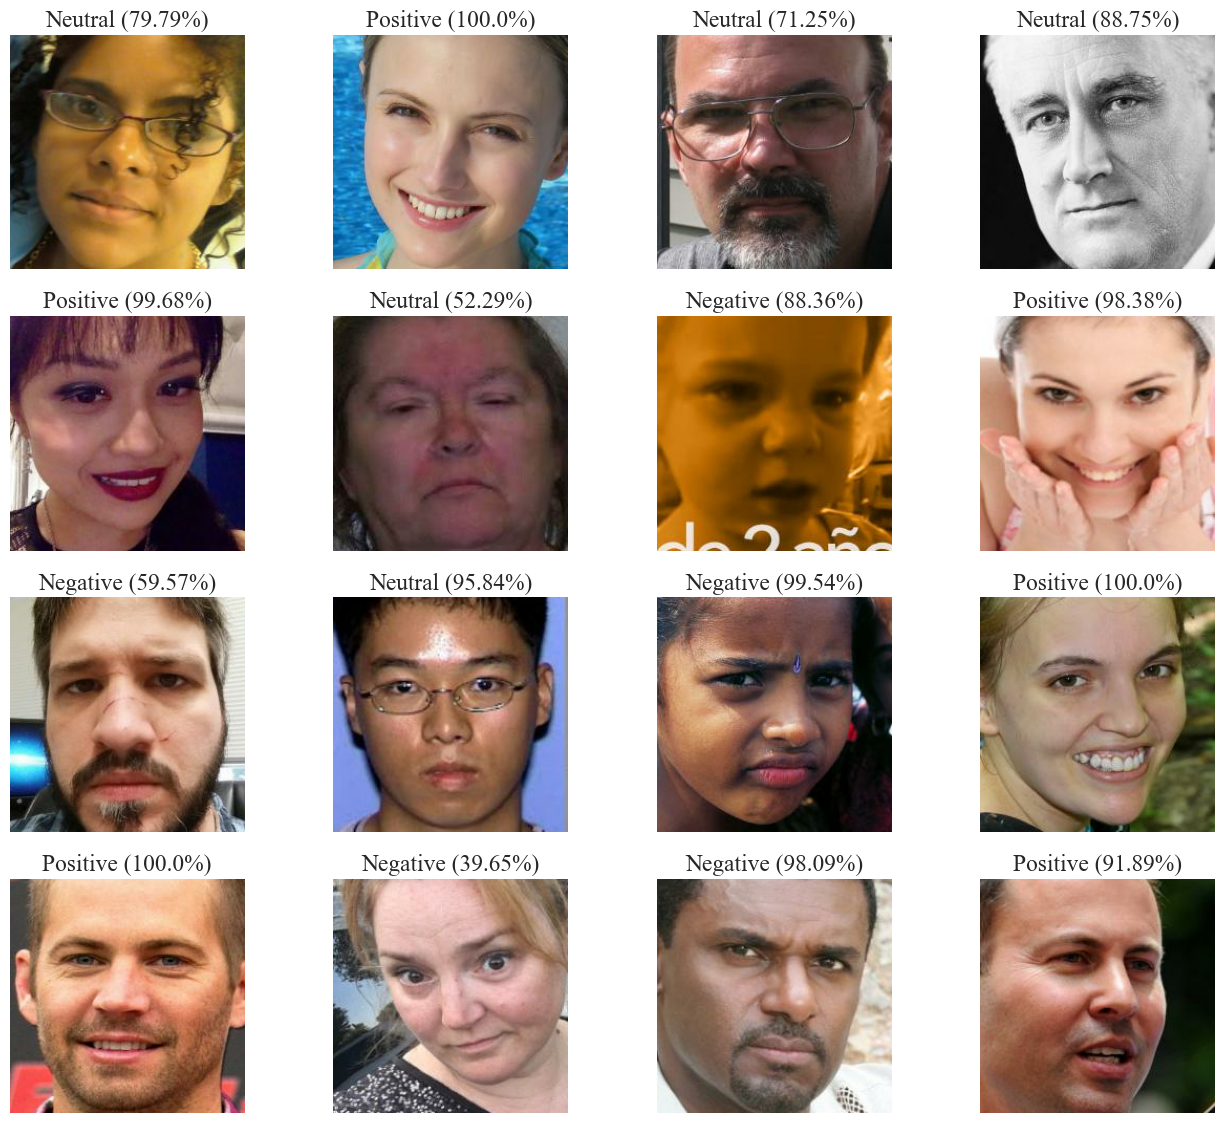

In [9]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
fig = plt.figure(figsize=(16, 14))

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_path_structured, "val_set"), 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=image_shape[0:2],
    seed=101, 
    shuffle=True)

# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        image = images[i+64].numpy().astype("uint8")
        img_array = keras.utils.img_to_array(image)
        img_array = np.expand_dims(img_array, 0) # Create a batch

        plt.imshow(image)
        img_prediction = affective_model.predict(img_array, verbose=0)
        plt.title(f"{class_names[np.argmax(img_prediction)]} ({np.round(100*np.max(softmax(img_prediction)), 2)}%)")
        plt.axis("off")
        
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.savefig("figures/affective_predictions.png", bbox_inches='tight')
plt.show()

# Spiral analytics

In [10]:
from joblib import load
from consultation.modules.spiral_test import create_feature, augment_data
import pandas as pd

def drop_cols(df):
    return df.drop(["z_pos", "pressure", "grip_angle", "test_id"], axis=1)

regression_model = load("models/linear_regression_model.joblib")

from sklearn.preprocessing import LabelBinarizer

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
col_names = ["x_pos", "y_pos", "z_pos", "pressure", "grip_angle", "time", "test_id"]

feature_df = pd.DataFrame(data=None, columns=(["label", "set_id"] + [f"predictor_{idx}" for idx in range(9)]))

base_path = "spiral_analytics/hw_dataset"
times = []
for dataset in ("control", "parkinson"):
    file_names = os.listdir(f"{base_path}/{dataset}")
    file_paths = [os.path.join(base_path, dataset, file_name) for file_name in file_names if ".txt" in file_name]
    for idx, file_path in enumerate(file_paths):
        test_data = pd.read_csv(file_path, sep=";", names=col_names)
        static_data = test_data.loc[test_data["test_id"] == 0]
        if dataset == "parkinson":
            times.append(max(static_data["time"] - min(static_data["time"])))
        static_data_aug = drop_cols(static_data)
        static_data_aug = augment_data(static_data_aug, spiral_radius=200, invert_y=True)
        spiral_feature = create_feature(static_data_aug)
        if dataset == "parkinson":
            label = 1
        else:
            label = 0
            
        feature_df.loc[len(feature_df)] = np.append([label, idx], spiral_feature)

In [12]:
def partition_data(df, train_split, even_classes=True):
    control_count = sum(df["label"] == 0)
    nd_count = sum(df["label"] == 1)
    if even_classes:
        class_count = min(control_count, nd_count)
        control_train_ids = np.random.permutation(range(control_count))[:int(class_count*train_split)]
        nd_train_ids = np.random.permutation(range(nd_count))[:int(class_count*train_split)]
    else:
        control_train_ids = np.random.permutation(range(control_count))[:int(control_count*train_split)]
        nd_train_ids = np.random.permutation(range(nd_count))[:int(nd_count*train_split)]
    
    control_val_ids = np.array([idx for idx in range(control_count) if not np.isin(idx, control_train_ids)])
    nd_val_ids = np.array([idx for idx in range(nd_count) if not np.isin(idx, nd_train_ids)])
    
    train_df = df.loc[np.logical_or(
        np.logical_and((df["label"] == 0), np.isin(df["set_id"], control_train_ids)), 
        np.logical_and((df["label"] == 1), np.isin(df["set_id"], nd_train_ids)))]
    
    val_df = df.loc[np.logical_or(
        np.logical_and((df["label"] == 0), np.isin(df["set_id"], control_val_ids)), 
        np.logical_and((df["label"] == 1), np.isin(df["set_id"], nd_val_ids)))]
    
    return train_df, val_df

In [13]:
from sklearn import svm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit


even_class = True
enc = OneHotEncoder().fit(np.array([[0, 1]]))
linear_preds = np.empty([16, 2, 0])
logistic_preds = np.empty([16, 2, 0])
mlp_predictions = np.empty([16, 2, 0])
svm_predictions = np.empty([16, 2, 0])
val_true = np.empty([16, 2, 0])

conf_matrix_array = np.empty([2, 2, 0])

best_cost = 100
best_model = None
label_binarizer = LabelBinarizer().fit([0, 1])
scaler = StandardScaler()
linear_model = LinearRegression()
logistic_model = LogisticRegression(max_iter=100000)
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 20), random_state=1, max_iter=int(1e7))
svm_clf = svm.SVC(kernel="poly", degree=2, probability=True)

for fold in range(200):
    train_set, val_set = partition_data(feature_df, 0.8, even_classes=True)
    
    train_data = train_set.drop(["label", "set_id"], axis=1)
    val_data = val_set.drop(["label", "set_id"], axis=1)
    print(train_set.shape, val_data.shape)
    
    # train_data = scaler.fit_transform(train_data)
    # val_data = scaler.transform(val_data)
    
    logistic_model.fit(train_data, train_set.label)
    linear_model.fit(train_data, train_set.label)
    mlp.fit(scaler.fit_transform(train_data), train_set.label)
    svm_clf.fit(train_data, train_set.label)
    
    logistic_pred = logistic_model.predict_proba(val_data)
    linear_sig = expit(linear_model.predict(val_data))
    
    linear_pred = np.concatenate([np.expand_dims(1-linear_sig, axis=1), np.expand_dims(linear_sig, axis=1)], axis=1)
    
    mlp_pred = mlp.predict_proba(scaler.transform(val_data))
    
    svm_pred = svm_clf.predict_proba(val_data)
    # svm_predictions.append(svm_acc)
    
    # cm = confusion_matrix(classification, val_set.label)
    # conf_matrix_array = np.append(conf_matrix_array, np.expand_dims(cm, axis=2), axis=2)
    
    logistic_preds = np.append(logistic_preds, np.expand_dims(logistic_pred, axis=2), axis=2)
    linear_preds = np.append(linear_preds, np.expand_dims(linear_pred, axis=2), axis=2)
    mlp_predictions = np.append(mlp_predictions, np.expand_dims(mlp_pred, axis=2), axis=2)
    svm_predictions = np.append(svm_predictions, np.expand_dims(svm_pred, axis=2), axis=2)
    
    val_true = np.append(val_true, np.expand_dims(pd.get_dummies(val_set.label), axis=2), axis=2)


(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 9)
(24, 11) (16, 

In [14]:
# Logistic regression!!
print(linear_preds.shape, val_true.shape)

(16, 2, 200) (16, 2, 200)


In [15]:


def calculate_metrics(pred, true):
    conf_matrix = confusion_matrix(np.argmax(true, axis=1), np.argmax(pred, axis=1))
    
    precision = metrics.precision_score(np.argmax(true, axis=1), np.argmax(pred, axis=1))
    recall = metrics.recall_score(np.argmax(true, axis=1), np.argmax(pred, axis=1))
    
    # print(conf_matrix)
    # tn = conf_matrix[0, 0]
    # fn = conf_matrix[0, 1]
    # fp = conf_matrix[1, 0]
    # tp = conf_matrix[1, 1]
    
    return precision, recall

linear_pred_sum = np.sum(linear_preds, axis=2)
linear_true_sum = np.sum(val_true, axis=2)

linear_pred_all = np.concatenate([linear_preds[:, :, idx] for idx in range(linear_preds.shape[2])])
logistic_pred_all = np.concatenate([logistic_preds[:, :, idx] for idx in range(logistic_preds.shape[2])])
mlp_pred_all = np.concatenate([mlp_predictions[:, :, idx] for idx in range(mlp_predictions.shape[2])])
svm_pred_all = np.concatenate([svm_predictions[:, :, idx] for idx in range(svm_predictions.shape[2])])
val_true_all = np.concatenate([val_true[:, :, idx] for idx in range(val_true.shape[2])])

# print(linear_pred_all)
linear_accuracy = accuracy_score(np.argmax(linear_pred_all, axis=1), np.argmax(val_true_all, axis=1))
logistic_accuracy = accuracy_score(np.argmax(logistic_pred_all, axis=1), np.argmax(val_true_all, axis=1))
mlp_accuracy = accuracy_score(np.argmax(mlp_pred_all, axis=1), np.argmax(val_true_all, axis=1))
svm_accuracy = accuracy_score(np.argmax(svm_pred_all, axis=1), np.argmax(val_true_all, axis=1))

print(f"Linear Accuracy: {linear_accuracy}")
print(f"Logistic Accuracy: {logistic_accuracy}")
print(f"MLP Accuracy: {mlp_accuracy}")
print(f"SVM Accuracy: {svm_accuracy}")
model_accuracies = [linear_accuracy, logistic_accuracy, mlp_accuracy, svm_accuracy]

print(calculate_metrics(linear_pred_all, val_true_all))
print(calculate_metrics(logistic_pred_all, val_true_all))
print(calculate_metrics(mlp_pred_all, val_true_all))
print(calculate_metrics(svm_pred_all, val_true_all))



Linear Accuracy: 0.845
Logistic Accuracy: 0.6484375
MLP Accuracy: 0.769375
SVM Accuracy: 0.6128125
(0.8561272850372377, 0.9726923076923077)
(0.9159616469261139, 0.6246153846153846)
(0.9326208178438662, 0.7719230769230769)
(0.8370480435859337, 0.65)


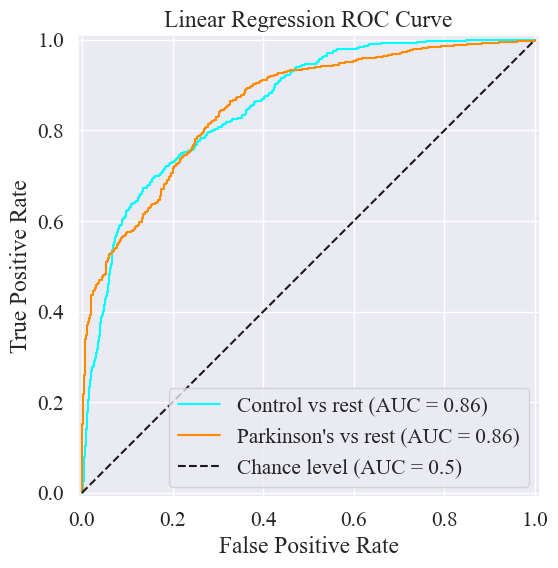

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True, sharey=True)
class_names = ["Control", "Parkinson's"]
colours = ["aqua", "darkorange", "cornflowerblue"]
for class_id in [0, 1]:
    display = RocCurveDisplay.from_predictions(
        val_true_all[:, class_id],
        linear_pred_all[:, class_id],
        name=f"{class_names[class_id]} vs rest",
        color=colours[class_id],
        plot_chance_level=(class_id == 1),
        ax=ax,
    )
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Linear Regression ROC Curve",
)
plt.savefig("figures/spiral_linear_roc.png", bbox_inches='tight')

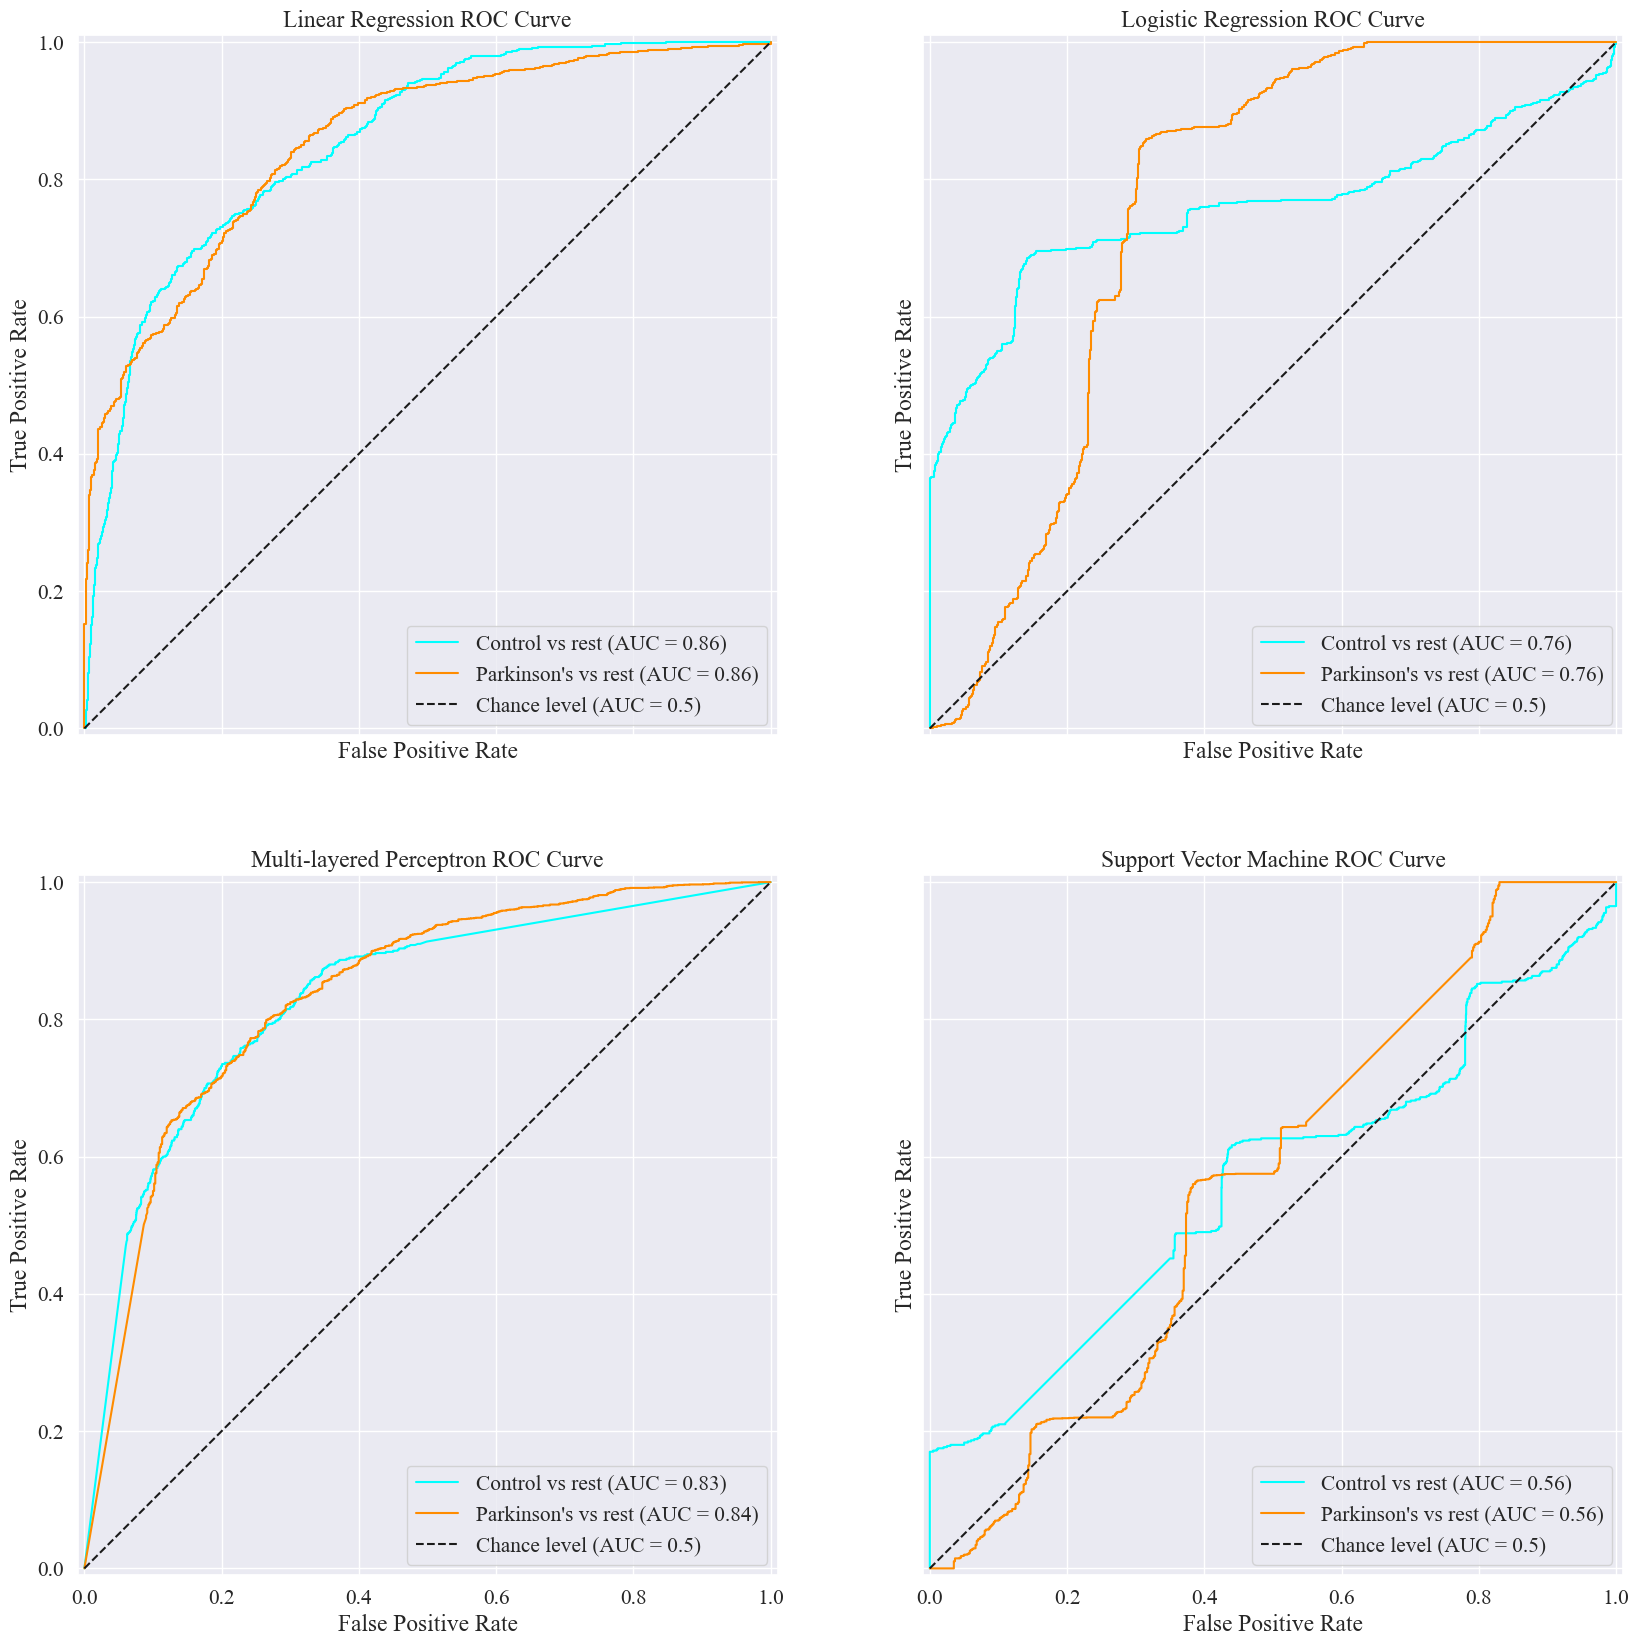

In [17]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]


classifiers = ["Linear Regression", "Logistic Regression", "Multi-layered Perceptron", "Support Vector Machine"]
def create_roc_plot(y_pred, x, y):
    class_names = ["Control", "Parkinson's"]
    colours = ["aqua", "darkorange", "cornflowerblue"]
    for class_id in [0, 1]:
        display = RocCurveDisplay.from_predictions(
            val_true_all[:, class_id],
            y_pred[:, class_id],
            name=f"{class_names[class_id]} vs rest",
            color=colours[class_id],
            plot_chance_level=(class_id == 1),
            ax=ax[x, y],
        )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{classifiers[(x*2)+y]} ROC Curve",
    )

fig, ax = plt.subplots(2, 2, figsize=(20, 20), sharex=True, sharey=True)
create_roc_plot(linear_pred_all, 0, 0)
create_roc_plot(logistic_pred_all, 0, 1)
create_roc_plot(mlp_pred_all, 1, 0)
create_roc_plot(svm_pred_all, 1, 1)

plt.savefig("figures/spiral_classifiers_roc.png", bbox_inches='tight')